In [1]:
using GraphRecipes
using Plots
using DelimitedFiles
using LinearAlgebra
using SparseArrays
using Random
Random.seed!(1234);  # determinism
plot([1], [1]);      # pre-compile

In [2]:
# Generate SBM
function two_block_SBM(n1::Int64, n2::Int64, p::Float64, q::Float64)
    A = zeros(n1 + n2, n1 + n2)
    for i = 1:n1, j = (i+1):n1  # block 1
        if rand() <= p; A[i, j] = 1; end
    end
    for i = 1:n2, j = (i+1):n2 # block 2
        if rand() <= p; A[i + n1, j + n1] = 1; end
    end
    for i = 1:n1, j = 1:n2
        if rand() <= q; A[i, j + n1] = 1; end
    end
    return sparse(max.(A, A'))
end

A = two_block_SBM(100, 100, 0.7, 0.2)
spy(A, legend=nothing, m=:heat)

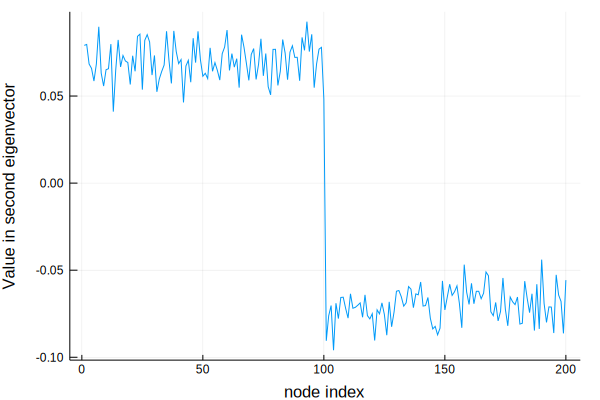

In [3]:
function second_evec_Laplacian(A; normalized=false)
    d = vec(sum(A, dims=1))
    D = Diagonal(d)
    Dinv = Diagonal(d .^ (-1/2))
    L = Diagonal(d) - A
    if normalized; L = Dinv * L * Dinv; end
    v2 = eigen(Matrix(L)).vectors[:, 2]
    if normalized; v2 = Dinv * v2; end
    return v2
end

v2 = second_evec_Laplacian(A)
plot(v2, label="", xlabel="node index",
     ylabel="Value in second eigenvector")

In [4]:
A = two_block_SBM(150, 50, 0.6, 0.2)
spy(A, legend=nothing, m=:heat)

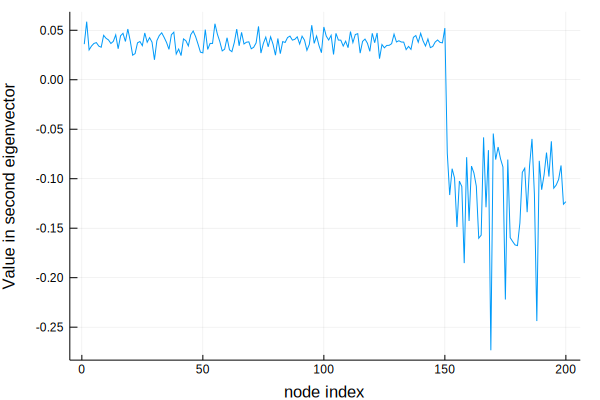

In [5]:
v2 = second_evec_Laplacian(A)
plot(v2, label="", xlabel="node index",
     ylabel="Value in second eigenvector")

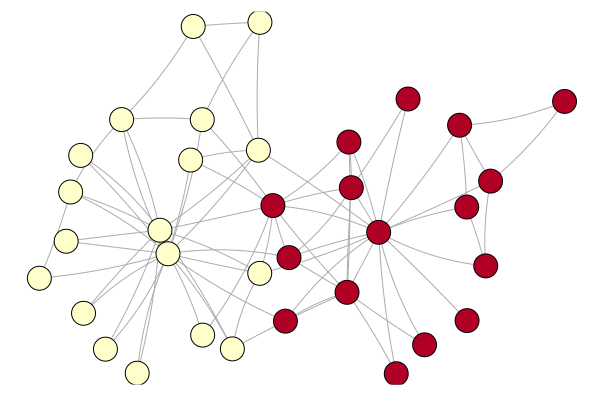

In [6]:
# Read Zachary's karate club
data = readdlm("zacharys-KC.txt")
n = 34
A = sparse(convert(Vector{Int64}, data[:,1]),
           convert(Vector{Int64}, data[:,2]), 1, n, n)
labels = zeros(n)
group1 = [1,2,3,4,5,6,7,8,11,12,13,14,17,18,20,22]
group2 = [i for i in 1:n if !(i in group1)]
labels[group1] .= 1
colors = ["blue" for _ in 1:n]
colors[labels .== 1] .= "red"
A = max.(A, A');

Random.seed!(1345)  # plot same each time
plot(
    graphplot(A,
              method=:stress,
              marker = (:YlOrRd, :circ),
              marker_z = labels,
              linecolor = :darkgrey,
             )
)

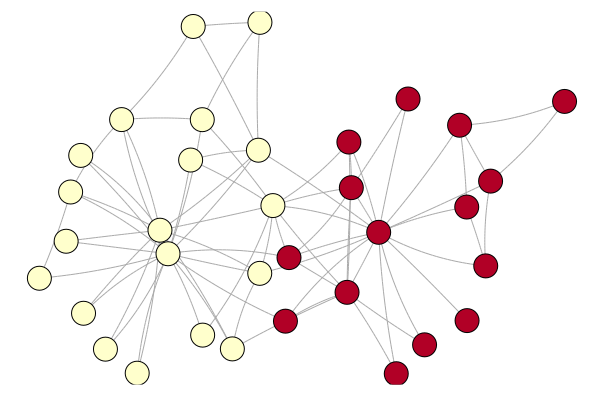

In [7]:
v2 = second_evec_Laplacian(A)
rcut_labels = zeros(n)
rcut_labels[findall(v2 .> 0)] .= 1

Random.seed!(1345)  # plot same each time
plot(
    graphplot(A,
              method=:stress,
              marker = (:YlOrRd, :circ),
              marker_z = rcut_labels,
              linecolor = :darkgrey
             )
)

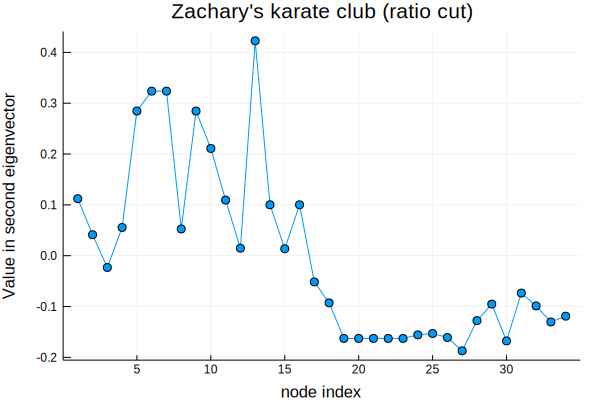

In [8]:
plot([v2[group1]; v2[group2]], marker=:circle, label="",
     xlabel="node index", ylabel="Value in second eigenvector",
     title="Zachary's karate club (ratio cut)")

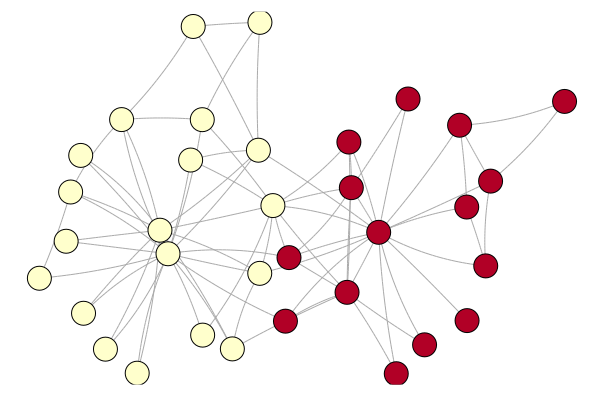

In [9]:
v2 = second_evec_Laplacian(A, normalized=true)
ncut_labels = zeros(n)
ncut_labels[findall(v2 .> 0)] .= 1

Random.seed!(1345)  # plot same each time
plot(
    graphplot(A,
              method=:stress,
              marker = (:YlOrRd, :circ),
              marker_z = ncut_labels,
              linecolor = :darkgrey
             )
)

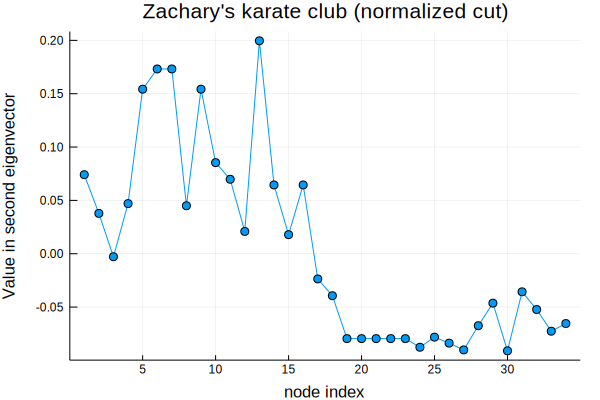

In [10]:
plot([v2[group1]; v2[group2]], marker=:circle, label="",
     xlabel="node index", ylabel="Value in second eigenvector",
     title="Zachary's karate club (normalized cut)")

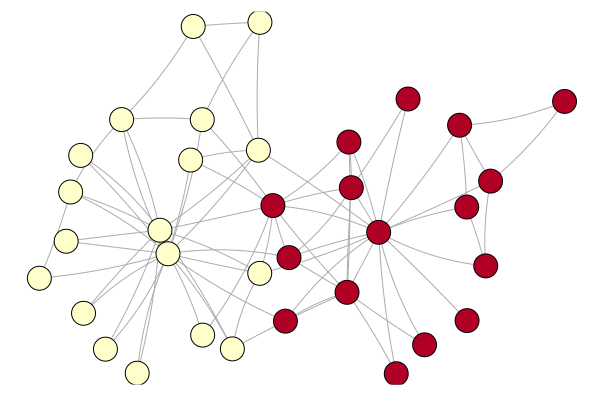

In [11]:
# sweep cut
function ncut(S::Vector{Int64})
    T = ones(n)
    T[S] .= 0
    T = findall(T .> 0)
    cut = sum(A[S, T])
    return cut / sum(A[:, S]) + cut / sum(A[:, T])
end

verts = Vector{Int64}()
ncut_vals = []
σ = sortperm(v2, rev=true)
for s in σ[1:(n-1)]
    push!(verts, s)
    push!(ncut_vals, ncut(verts))
end
sweep_labels = zeros(n)
sweep_labels[σ[1:argmin(ncut_vals)]] .= 1

Random.seed!(1345)  # plot same each time
plot(
    graphplot(A,
              method=:stress,
              marker = (:YlOrRd, :circ),
              marker_z = sweep_labels,
              linecolor = :darkgrey
             )
)